# ECON 8185 - HW 3

João Lazzaro - santo279@umn.edu

## Question 1

In this question we were asked to write a code to compute the MLE estimator for the parameters of HW2 model: 

$$\max_{c_t,x_t,l_t} E \sum_{t=0}^\infty \beta^t \frac{\left(c_tl_t^\psi\right)^{1-\sigma}}{1-\sigma} N_t$$
S.T. 
$$ c_t +(1+\tau_{xt})x_t =r_t k_t +(1-\tau_{ht})w_t h_t + T_t$$
$$ N_{t+1} k_{t+1} = [(1-\delta)k_t+x_t]N_t$$
$$h_t+l_t =1$$
$$S_t = P S_{t-1}+Q\epsilon_t,\;\;S_t = [\ln z_t,\tau_{ht},\tau_{xt}, \ln g_t]$$
$$ c_t,x_t\geq0$$

Where $N_t = (1+\gamma_n)^t$ and firm tecnhology is $Y_t = K_t^\theta (Z_t L_t)^{1-\theta}$. $\gamma_z$ is the rate of labor-augmenting technical progress. The stochastic shocks hitting this economy affect technology, tax rates, and government spending and the stochastic processes are modeled as a VAR(1) process. The resource constraint is $Y_t=N_t(c_t +x_t +g_t)$. We must work with detrended variables, we should use "hat" variables, but typing this is time consuming so from now on all variables should be understood as detrended unless I say something about them.

Let's first define some parameters for this model:

In [23]:
using NLsolve, ForwardDiff, LinearAlgebra, Random, JLD2,FileIO
using Optim, Statistics, NLSolversBase,LaTeXStrings, Plots

#Parameters:
δ = 0.0464   #depreciation rate
θ = 1/3  #capital share of output
β = 0.9  #Discouting
σ = 2  #Elasticity of Intertemporal Substitution
ψ = 1    #Labor parameter
γn= 0.00    #Population growth rate
γz= 0.00   #Productivitu growth rate

0.0

We'll assume, for now, that matrices P and Q are the following:

In [68]:
#Parameters to be estimated and here used in our simulated example
gss = log(0.01) #average g (in logs)
τxss = 0.05 #average τx
τhss = 0.02 #average τh
zss = log(1) #average z (z is in logs)

#Parameters to be estimated
ρg = 0.8
ρx = 0.5
ρh = 0.7
ρz = 0.9
ρzg= 0.0
ρzx = 0.0
ρzh = 0.0
ρhz = 0.0
ρhx = 0.0
ρhg = 0.0
ρxz = 0.0
ρxh = 0.0
ρxg = 0.0
ρgz = 0.0
ρgx = 0.0
ρgh = 0.0

σg= 0.02
σx = 0.01
σz = 0.02
σh = 0.01
σzg= 0.0
σzx = 0.00
σzh = 0.0
σhx = 0.0
σhg = 0.0
σxg = 0.0

#In matrix form
P = [ρz ρzh ρzx ρzg;
ρhz ρh ρhx ρhg ;
ρxz ρxh ρx ρxg ;
ρgz ρgh ρgx ρg]
Q = [σz σzh σzx σzg;
σzh σh σhx σhg ;
σzx σhx σx σxg ;
σzg σhg σxg σg]
P,Q

([0.9 0.0 0.0 0.0; 0.0 0.7 0.0 0.0; 0.0 0.0 0.5 0.0; 0.0 0.0 0.0 0.8], [0.02 0.0 0.0 0.0; 0.0 0.01 0.0 0.0; 0.0 0.0 0.01 0.0; 0.0 0.0 0.0 0.02])

In HW2, I describe how to approximate and write the model in the state space form:
$$ X_{t+1} = AX_t + B \varepsilon_{t+1}$$
$$Y_t = CX_t+\omega_t$$
Where, $X_t = [k_t,S_t],S_t=[z_t,\tau_{ht},\tau_{xt},g_t]$, $Y_t = [y_t,x_t,h_t]$ and as before:
$$S_{t+1} = P S_t +Q \varepsilon_{t+1}$$

The function below, defined in HW2, finds Matrices $A,B$ and $C$, given pthe parameters:

In [69]:
include("State_Space.jl")

params_calibrated = [δ,θ,β,σ,ψ,γn,γz,]
steadystates = [gss,τxss,τhss,zss]

A,B,C = State_Space(params_calibrated,steadystates, P,Q)

([0.837781 0.135625 … -0.00873329 -0.000178252; 0.0 0.9 … 0.0 0.0; … ; 0.0 0.0 … 0.5 0.0; 0.0 0.0 … 0.0 0.8], [0.0 0.0 … 0.0 0.0; 0.0 0.02 … 0.0 0.0; … ; 0.0 0.0 … 0.01 0.0; 0.0 0.0 … 0.0 0.02], [0.462731 0.749108 … -0.00725869 0.00671295; -2.4961 2.92296 … -0.188217 -0.00384163; 0.194096 0.123661 … -0.010888 0.0100694; 0.0 0.0 … 0.0 1.0])

Given the model we simulate some data:

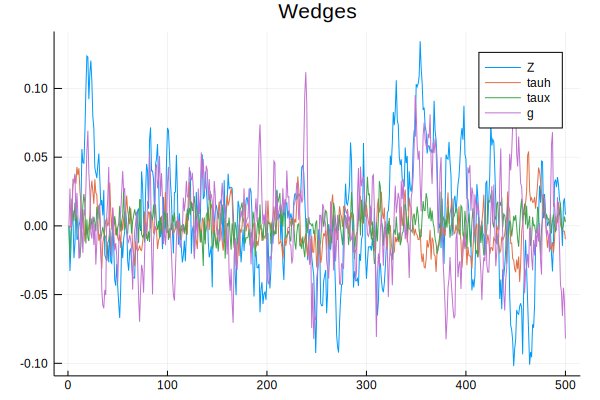

In [70]:
T=500
X= zeros(5,T)
Y = zeros(4,T)

Random.seed!(0403);
S = randn(5,T) #vector with shocks

#Simulating data
for t=1:T
    if t>1
    X[:,t] = A*X[:,t-1]+ B*S[:,t]
    end
    Y[:,t] = C*X[:,t]
end
plot([X[2,:],X[3,:],X[4,:],X[5,:]],title ="Wedges", labels = ["Z","tauh","taux","g"])

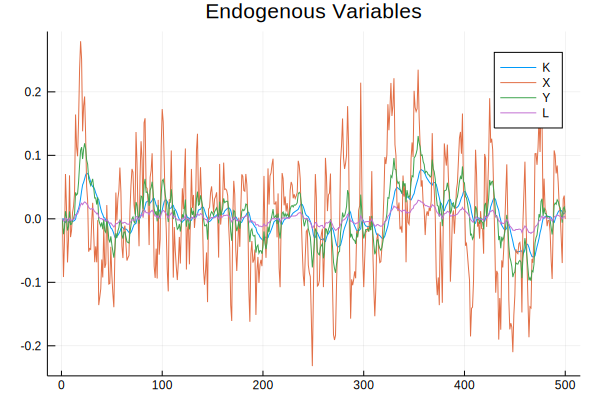

In [71]:
plot([X[1,:],Y[2,:],Y[1,:],Y[3,:]],title = "Endogenous Variables",labels = ["K","X","Y","L"])

Given the simulated data above, we want to build an algorithm to estimate the matrices P and Q (and the steady state values) such that we would have the same data generating process. To do that, we'll build a likelihood function using the Kalman Filter. We follow Ljunqvist & Sargent exposition of the Kalman filter. Assume for a slightly more general case that $\omega_t$ is an iid vector sequence of normal random variances with mean zero and covariance matrix $R$ (In our case, $R=0$).  

We observe $Y_t$ but not $X_t$. We want to estimate $\hat{X}_t = E[X_t|Y^{t-1}]$ and also the covariances $\Sigma_t = E[(X_t-\hat{X}_t)(X_t-\hat{X}_t)']$. The trick is to use the new information in $y_0$ relative to what we know ($\hat{X}_0$):    $a_0:=Y_0-C\hat{X}_0$. $a_t:=Y_t-C\hat{X}_t$. Regressing the model: $$X_0-\hat{X}_0 = L_0a_0+\eta$$ We get that:
$$L_0 = \Sigma_0 C'\left(C\Sigma_0 C'+R\right)^{-1} $$

Defining $\hat{X}_1 = E[X_1|Y_0] = A X_0$: 
$$X_1 = A\hat{X}_0 + A\left(X_0-\hat{X}_0\right) + B \varepsilon_1$$

Substituting the linear model and $L_0$:
$$\hat{X}_1 = A\hat{X}_0 +K_0(Y_0 - C \hat{X}_0) $$

Where $K_0 = AL_0$ is the Kalman gain. Plugging these equations: $X_1-\hat{X}_1 = A (X_0-\hat{X}_0) +B \varepsilon_1 - K_0(Y_0-C\hat{X}_0)$ and we may compute a new variance matrix $\Sigma_1 = E(X_1-\hat{X}_1)(X_1-\hat{X}_1)$:
$$\Sigma_1 = (A-K_0C)\Sigma_0(A-K_0C)' + (BB'+K_0RK_0')$$


Iterating the above steps we get te Kalman filter recursion:
$$a_t = Y_t-C\hat{X}_t$$
$$K_t = A\Sigma_tC'(C\Sigma_tC'+R)^{-1}$$
$$\hat{X}_{t+1} = A\hat{X}_t + K_t a_t$$
$$\Sigma_{t+1} = (A-K_tC)\Sigma_t(A-K_tC)' + (BB'+K_tRK_t')$$

The code below implements this recursion:

In [72]:
function KalmanFilter(Y,A,B,C)
#Y: Observed variables


n = size(A)[1] #number of state variables
m = size(C)[1] #number of measurement variables
T = size(Y)[2] #Sample size

#Initializing the state variables
X = zeros(n,T)
#Variance initial guess
Σ = ones(n,n)*ones(n,n)'
d=10
while d>10^(-15)
    Σ1 = A*Σ*A' + B*B'
    d = maximum(abs.(Σ-Σ1))
    Σ=Σ1
end

#Run the Kalman filter algorithm (see Ljunqvist sargent)
a=ones(m,T)
Ω = C*Σ*C'
for t = 1:T-1
    a[:,t] = Y[:,t] - C*X[:,t]
    K = A*Σ*C' / (C*Σ*C')
    X[:,t+1] = A*X[:,t] +K*a[:,t]
    Σ = B*B' + (A-K*C)*Σ*(A-K*C)'
    Ω = [Ω C*Σ*C']
end
a[:,T] = Y[:,T] - C*X[:,T]
Ω = [Ω C*Σ*C']

return X, a, Ω
end

KalmanFilter (generic function with 1 method)

Note that we set, in the code above, the initial $\Sigma_0$ such that $\Sigma_0 = A\Sigma_0A' +BB$. 

The innovations representation that emerges from the Kalman filter is: 
$$\hat{X}_{t+1} = A\hat{X}_t+K_t a_t$$
$$Y_t = C \hat{X}_t +a_t $$
Define: $\Omega_t :=E[a_ta'_t] = C \Sigma_tC'+R$. We have that $E[Y_t|Y^{t-1}] = C\hat{X}_t$ and the conditional distribution of $Y_t$ is $N(C\hat{X}_t,\Omega_t)$. Therefore, $C\hat{X}_t,\Omega_t$ are sufficient statistics for the conditional distribution of $Y_t$. Note that we can factor the likelihood function as:
$$f(Y_T,...Y_0) = f(Y_T|Y^{T-1})f(Y_{T-1}|Y^{T-2})...f(Y_1|Y_0)f(Y_0)$$

And the log of the conditional density of the $m \times 1$ vector $Y_t$ is:\
$$\log f(Y_t|Y^{t-1}) = -0.5m \log(2\pi) - 0.5 \log(\det(\Omega_t)) -0.5 a_t'\Omega_t^{-1} a_t$$

The code below builds the log likelihood function using the method above:

In [73]:
function likelihood(Y,Ω,a)
    m,T = size(Y)
    L = 0
for t=1:T
    iteration = t
    L = L + (-0.5*m * log(2*π)-0.5*log(det(Ω[:,m*t-(m-1):(m*t)])) -
    0.5*a[:,t]'*(Ω[:,m*t-(m-1):(m*t)]\a[:,t]))
end
return L
end

likelihood (generic function with 1 method)

With the likelihood function, we can estimate parameters $\theta$ given a vector of data $Y$. Now, back to our exercise, the code below we may define the subset of parameters to be estimated and writes down a function to in the optimizer format. 

In [74]:
function maxloglikelihood(vector::Vector;Y=Y)
    #ρg,ρx,ρh,ρz,σg,σx,σz,σh=vector
    ρg,ρx,ρh,ρz=vector
    #ρg,ρx,ρh,ρz,ρzg,ρzx,ρzh,ρhz,ρhx,ρhg,ρxz,ρxh,ρxg,ρgz,ρgx,ρgh,σg,σx,σz,σh,σzg,σzx,σzh,σhx,σhg,σxg,gss,τxss,τhss,zss = vector
    #ρg,ρx,ρh,ρz,ρzg,ρzx,ρzh,ρhz,ρhx,ρhg,ρxz,ρxh,ρxg,ρgz,ρgx,ρgh,σg,σx,σz,σh,σzg,σzx,σzh,σhx,σhg,σxg = vector

    #In matrix form
    P = [ρz ρzh ρzx ρzg;
    ρhz ρh ρhx ρhg ;
    ρxz ρxh ρx ρxg ;
    ρgz ρgh ρgx ρg]

    Q = [σz σzh σzx σzg;
    σzh σh σhx σhg ;
    σzx σhx σx σxg ;
    σzg σhg σxg σg]

    steadystates = gss,τxss,τhss,zss
    params_calibrated = [δ,θ,β,σ,ψ,γn,γz]


    A,B,C = State_Space(params_calibrated,steadystates, P,Q)
    X, a, Ω = KalmanFilter(Y,A,B,C)
    L = -likelihood(Y,Ω,a)
    return L
end

maxloglikelihood (generic function with 1 method)

Note that the function above actually returns minus the log likelihood, since our optimizer is in fact a minimizer. Checking the value of 

## Question 2

We first begin estimating only 4 parameters and assuming all the others are known:

In [75]:
original = [ρg,ρx,ρh,ρz]

4-element Array{Float64,1}:
 0.8
 0.5
 0.7
 0.9

The likelihood valued at the true parameters is:

In [76]:
truelikelihood = maxloglikelihood(original)

-8981.827066845943

Our optimizer will use the LBFGS which is a variant of the Newton method with approximated Hessians and Gradients (see Judd's book for a BFGS explanation and Optim's documentation for LBFGS). Also, we'll only allow the optimizer to choose parameters that make sense. Our initial guess will be points normally distributed around the true ones.

In [77]:
Random.seed!(0403);
initial = original .+ randn(length(original))*0.5

#Solver Stuff
inner_optimizer = LBFGS() #LBFGS()  # SimulatedAnnealing() #NelderMead() ConjugateGradient()

#Defining lower and upper bounds for estimator
lower=zeros(length(initial))
upper = ones(length(initial))
#making sure that the initial guess is within the bounds
initial = min.(upper.*0.99,initial)
initial = max.(lower.+0.0001,initial)


bla = optimize(maxloglikelihood,lower,upper, initial,Fminbox(inner_optimizer),
    Optim.Options(show_trace = false, show_every = 10,iterations =500, time_limit = 60*60*1.0))
estimates = bla.minimizer

4-element Array{Float64,1}:
 0.7958110879114092
 0.4723633292032471
 0.7599029791356807
 0.8998483534903401

The optimizer found the parameters above, note that they are reasonably, close to the true parameters:

In [78]:
abs.(estimates - original)

4-element Array{Float64,1}:
 0.004188912088590846  
 0.027636670796752916  
 0.05990297913568077   
 0.00015164650965993065

Now we repat the exercise increasing the sample size:

In [79]:
T=1000
X= zeros(5,T)
Y = zeros(4,T)

Random.seed!(0403);
S = randn(5,T) #vector with shocks

#Simulating data
for t=1:T
    if t>1
    X[:,t] = A*X[:,t-1]+ B*S[:,t]
    end
    Y[:,t] = C*X[:,t]
end

Random.seed!(0403);
initial = original .+ randn(length(original))*0.5

#Solver Stuff
inner_optimizer = LBFGS() #LBFGS()  # SimulatedAnnealing() #NelderMead() ConjugateGradient()

#Defining lower and upper bounds for estimator
lower=zeros(length(initial))
upper = ones(length(initial))
#making sure that the initial guess is within the bounds
initial = min.(upper.*0.99,initial)
initial = max.(lower.+0.0001,initial)


bla = optimize(maxloglikelihood,lower,upper, initial,Fminbox(inner_optimizer),
    Optim.Options(show_trace = false, show_every = 10,iterations =500, time_limit = 60*60*1.0))
estimates = bla.minimizer

4-element Array{Float64,1}:
 0.8012571224415571
 0.4811230302480477
 0.7349804390553227
 0.8999601976625144

The estimation improved considerably:

In [80]:
abs.(estimates - original)

4-element Array{Float64,1}:
 0.001257122441557068 
 0.0188769697519523   
 0.034980439055322776 
 3.9802337485572714e-5

We keep this new sample size and now, we estimate  parameters in total:

In [81]:
function maxloglikelihood(vector::Vector;Y=Y)
    ρg,ρx,ρh,ρz,σg,σx,σz,σh=vector
    #ρg,ρx,ρh,ρz=vector
    #ρg,ρx,ρh,ρz,ρzg,ρzx,ρzh,ρhz,ρhx,ρhg,ρxz,ρxh,ρxg,ρgz,ρgx,ρgh,σg,σx,σz,σh,σzg,σzx,σzh,σhx,σhg,σxg,gss,τxss,τhss,zss = vector
    #ρg,ρx,ρh,ρz,ρzg,ρzx,ρzh,ρhz,ρhx,ρhg,ρxz,ρxh,ρxg,ρgz,ρgx,ρgh,σg,σx,σz,σh,σzg,σzx,σzh,σhx,σhg,σxg = vector

    #In matrix form
    P = [ρz ρzh ρzx ρzg;
    ρhz ρh ρhx ρhg ;
    ρxz ρxh ρx ρxg ;
    ρgz ρgh ρgx ρg]

    Q = [σz σzh σzx σzg;
    σzh σh σhx σhg ;
    σzx σhx σx σxg ;
    σzg σhg σxg σg]

    steadystates = gss,τxss,τhss,zss
    params_calibrated = [δ,θ,β,σ,ψ,γn,γz]


    A,B,C = State_Space(params_calibrated,steadystates, P,Q)
    X, a, Ω = KalmanFilter(Y,A,B,C)
    L = -likelihood(Y,Ω,a)
    return L
end

maxloglikelihood (generic function with 1 method)

The parameters being estimated are:

In [83]:
original = [ ρg,ρx,ρh,ρz,σg,σx,σz,σh]

8-element Array{Float64,1}:
 0.8 
 0.5 
 0.7 
 0.9 
 0.02
 0.01
 0.02
 0.01

In [84]:
Random.seed!(0403);
initial = original .+ randn(length(original))*0.5

#Solver Stuff
inner_optimizer = LBFGS() #LBFGS()  # SimulatedAnnealing() #NelderMead() ConjugateGradient()

#Defining lower and upper bounds for estimator
lower=zeros(length(initial))
upper = ones(length(initial))
#making sure that the initial guess is within the bounds
initial = min.(upper.*0.99,initial)
initial = max.(lower.+0.0001,initial)


bla = optimize(maxloglikelihood,lower,upper, initial,Fminbox(inner_optimizer),
    Optim.Options(show_trace = false, show_every = 10,iterations =500, time_limit = 60*60*1.0))
estimates = bla.minimizer

8-element Array{Float64,1}:
 0.8012015032562366  
 0.47940910319609964 
 0.7350060714175761  
 0.899960552652651   
 0.02021940821204587 
 0.009956165110272584
 0.019867784560668324
 0.009759963840907413

The estimation is also quite good:

In [85]:
abs.(estimates - original)

8-element Array{Float64,1}:
 0.0012015032562365802 
 0.02059089680390036   
 0.03500607141757617   
 3.944734734906419e-5  
 0.00021940821204587124
 4.383488972741628e-5  
 0.0001322154393316767 
 0.0002400361590925871 

Now, we estimate all the Parameters with the exception of the Steady States and things start to get a little trickier:

In [86]:
function maxloglikelihood(vector::Vector;Y=Y)
    #ρg,ρx,ρh,ρz,σg,σx,σz,σh=vector
    #ρg,ρx,ρh,ρz=vector
    #ρg,ρx,ρh,ρz,ρzg,ρzx,ρzh,ρhz,ρhx,ρhg,ρxz,ρxh,ρxg,ρgz,ρgx,ρgh,σg,σx,σz,σh,σzg,σzx,σzh,σhx,σhg,σxg,gss,τxss,τhss,zss = vector
    ρg,ρx,ρh,ρz,ρzg,ρzx,ρzh,ρhz,ρhx,ρhg,ρxz,ρxh,ρxg,ρgz,ρgx,ρgh,σg,σx,σz,σh,σzg,σzx,σzh,σhx,σhg,σxg = vector

    #In matrix form
    P = [ρz ρzh ρzx ρzg;
    ρhz ρh ρhx ρhg ;
    ρxz ρxh ρx ρxg ;
    ρgz ρgh ρgx ρg]

    Q = [σz σzh σzx σzg;
    σzh σh σhx σhg ;
    σzx σhx σx σxg ;
    σzg σhg σxg σg]

    steadystates = gss,τxss,τhss,zss
    params_calibrated = [δ,θ,β,σ,ψ,γn,γz]


    A,B,C = State_Space(params_calibrated,steadystates, P,Q)
    X, a, Ω = KalmanFilter(Y,A,B,C)
    L = -likelihood(Y,Ω,a)
    return L
end

maxloglikelihood (generic function with 1 method)

In [87]:
original = [ ρg,ρx,ρh,ρz,ρzg,ρzx,ρzh,ρhz,ρhx,ρhg,ρxz,ρxh,ρxg,ρgz,ρgx,ρgh,σg,σx,σz,σh,σzg,σzx,σzh,σhx,σhg,σxg]

26-element Array{Float64,1}:
 0.8 
 0.5 
 0.7 
 0.9 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.02
 0.01
 0.02
 0.01
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 

In [ ]:
Random.seed!(0403);
initial = original .+ randn(length(original))*0.15


#Solver Stuff
inner_optimizer = LBFGS() #LBFGS()  # SimulatedAnnealing() #NelderMead() ConjugateGradient()


#Defining lower and upper bounds for estimator
lower=zeros(length(initial))

upper = ones(length(initial))
if length(initial) == 8
    upper[5:8] = 0.05 *ones(4)
end
if length(initial)>16
    upper[17:26] = 0.05.*ones(10)
    lower[5:16] = -1*ones(12)
end
if length(initial) == 30
    upper[27:30] = 0.1 * ones(4)
    lower[30] = -100 #z lower bound (in logs)
    lower[27] = -100 #g lower bound (in logs)
end
#making sure that the initial guess is within the bounds
initial = min.(upper.*0.99,initial)
initial = max.(lower.+0.0001,initial)


bla = optimize(maxloglikelihood,lower,upper, initial,Fminbox(inner_optimizer),Optim.Options(show_trace = true, show_every = 5,iterations =500, time_limit = 60*60*1.0))

estimates = bla.minimizer

######## fminbox ########
Initial mu = 0.003490576616956037
#### Fminbox #1: Calling optimizer with mu = 0.003490576616956037 ####
Iter     Function value   Gradient norm 
     0    -1.182265e+04     1.711374e+04
     5    -1.271863e+04     2.460528e+05
    10    -1.330823e+04     2.208305e+05
    15    -1.423519e+04     7.003060e+09
    20    -1.454465e+04     3.251963e+10


The estimates are fair:

In [ ]:
abs.(estimates - original)

Now, estimating all the 30 parameters:

In [ ]:
function maxloglikelihood(vector::Vector;Y=Y)
    #ρg,ρx,ρh,ρz,σg,σx,σz,σh=vector
    #ρg,ρx,ρh,ρz=vector
    ρg,ρx,ρh,ρz,ρzg,ρzx,ρzh,ρhz,ρhx,ρhg,ρxz,ρxh,ρxg,ρgz,ρgx,ρgh,σg,σx,σz,σh,σzg,σzx,σzh,σhx,σhg,σxg,gss,τxss,τhss,zss = vector
    #ρg,ρx,ρh,ρz,ρzg,ρzx,ρzh,ρhz,ρhx,ρhg,ρxz,ρxh,ρxg,ρgz,ρgx,ρgh,σg,σx,σz,σh,σzg,σzx,σzh,σhx,σhg,σxg = vector

    #In matrix form
    P = [ρz ρzh ρzx ρzg;
    ρhz ρh ρhx ρhg ;
    ρxz ρxh ρx ρxg ;
    ρgz ρgh ρgx ρg]

    Q = [σz σzh σzx σzg;
    σzh σh σhx σhg ;
    σzx σhx σx σxg ;
    σzg σhg σxg σg]

    steadystates = gss,τxss,τhss,zss
    params_calibrated = [δ,θ,β,σ,ψ,γn,γz]


    A,B,C = State_Space(params_calibrated,steadystates, P,Q)
    X, a, Ω = KalmanFilter(Y,A,B,C)
    L = -likelihood(Y,Ω,a)
    return L
end

In [ ]:
original = [ρg,ρx,ρh,ρz,ρzg,ρzx,ρzh,ρhz,ρhx,ρhg,ρxz,ρxh,ρxg,ρgz,ρgx,ρgh,σg,σx,σz,σh,σzg,σzx,σzh,σhx,σhg,σxg,gss,τxss,τhss,zss]

In [ ]:
Random.seed!(0403);
initial = original .+ randn(length(original))*0.15


#Solver Stuff
inner_optimizer = LBFGS() #LBFGS()  # SimulatedAnnealing() #NelderMead() ConjugateGradient()


#Defining lower and upper bounds for estimator
lower=zeros(length(initial))

upper = ones(length(initial))
if length(initial) == 8
    upper[5:8] = 0.05 *ones(4)
end
if length(initial)>16
    upper[17:26] = 0.05.*ones(10)
    lower[5:16] = -1*ones(12)
end
if length(initial) == 30
    upper[27:30] = 0.1 * ones(4)
    lower[30] = -100 #z lower bound (in logs)
    lower[27] = -100 #g lower bound (in logs)
end
#making sure that the initial guess is within the bounds
initial = min.(upper.*0.99,initial)
initial = max.(lower.+0.0001,initial)


bla = optimize(maxloglikelihood,lower,upper, initial,Fminbox(inner_optimizer),Optim.Options(show_trace = true, show_every = 5,iterations =500, time_limit = 60*60*1.0))

estimates = bla.minimizer

Assessing the accuracy:

In [ ]:
abs.(estimates - original)